# Section B: Practical questions with applied multiple choice

## General Rules:
- This is an open book examination.
- Students may make use of a calculator.
- This is an online examination where you will access a computer; however you may not communicate with other students in any form.
- Headphone are prohibited.
- The use of AI (chatGPT etc.) is prohibited.
- All cell phones are to be switched off for the duration of the exam.
- The invigilator will not assist you with the explanation of questions.
- Students are prohibited from conversing in any manner with other students.

## My Name and Surname

Name = 
</br>
Surname =  

### Part 1: SQL Queries  
You are provided with a pre-populated SQLite database named `airbnb.db`. Download [here](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) if you haven't already. Your task is to explore this database and write a series of SQL queries to perform the tasks detailed below. Queries should be optimised to run within 20 seconds or less.

The tables and columns included in the `airbnb.db` are:

- `listings`: `listing_id`, `host_id`, `listing_name`, `neighbourhood`, `room_type`, `price`, `minimum_nights`, `number_of_reviews`, `last_review`, `reviews_per_month`, `calculated_host_listings_count`, `availability_365`  
- `hosts`: `host_id`, `host_name`, `host_since`, `host_location`, `host_response_time`, `host_response_rate`, `host_is_superhost`  
- `reviews`: `review_id`, `listing_id`, `reviewer_id`, `review_date`, `comments`  
- `reviewers`: `reviewer_id`, `reviewer_name`  
- `calendar`: `listing_id`, `date`, `available`, `price`  
- `neighbourhoods`: `neighbourhood`, `borough`  
- `amenities`: `listing_id`, `amenity_name`

In [4]:
import os
import json
import random
import sqlite3
import sqlparse
import pandas as pd
import numpy as np

import seaborn as sns
import mysql.connector

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

# Load your database and create a database connection.
# You can connect to the sql database in any way you wish. 
# Use this method if you are unsure how to proceed. 
# Ensure the bike_store.db file is in the same directory as this notebook.
try:
    with sqlite3.connect("airbnb_nyc.db") as conn:
        print(f"Opened SQLite database with version {sqlite3.sqlite_version} successfully.")

except sqlite3.OperationalError as e:
    print("Failed to open database:", e)

# List all tables in the database
pd.read_sql('''SELECT name FROM sqlite_master WHERE type='table';''',conn)     #Does the same thing



#### SQL Query 1: Top 10 Neighbourhoods by Average Listing Price

#### This query helps identify the most expensive areas to stay in San Francisco.
#### It calculates the average price of listings per neighbourhood, excluding free or zero-priced listings,
#### and returns the top 10 neighbourhoods with the highest average prices.




In [6]:
import sqlite3
import pandas as pd

# Connect to SQLite database
try:
    with sqlite3.connect("airbnb_nyc.db") as conn:
        print(f"Opened SQLite database with version {sqlite3.sqlite_version} successfully.")
except sqlite3.OperationalError as e:
    print("Failed to open database:", e)


Opened SQLite database with version 3.49.1 successfully.


In [7]:
# Use existing connection to list tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)


                    name
0   neighbourhood_groups
1         neighbourhoods
2             room_types
3  cancellation_policies
4                  hosts
5               listings


Loading Data

In [8]:
df = pd.read_sql("SELECT * FROM listings;", conn)
df.head()


,id,name,host_id,neighbourhood_id,latitude,longitude,country,country_code,room_type_id,construction_year,...,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,instant_bookable,cancellation_policy_id,house_rules,license
0,1001254,Clean & quiet apt home by the park,-1589892906,1,40.64749,-73.97237,1,1,1,2020,...,9,None,0.21,4,6,286,0,1,Clean up and treat the home the way you'd like...,None
1,1002102,Skylit Midtown Castle,795565271,2,40.75362,-73.98377,1,1,2,2007,...,45,None,0.38,4,2,228,0,2,Pet friendly but please confirm with me if the...,None
2,1003689,Entire Apt: Spacious Studio/Loft by central park,1843282861,3,40.79851,-73.94399,1,1,2,2009,...,9,None,0.10,3,1,289,0,2,"Please no smoking in the house, porch or on th...",None
3,1004098,Large Cozy 1 BR Apartment In Midtown East,-1746088462,4,40.74767,-73.97500,1,1,2,2013,...,74,None,0.59,3,1,374,1,3,"No smoking, please, and no drugs.",None
4,1005202,BlissArtsSpace!,627526493,5,40.68688,-73.95596,1,1,1,2009,...,49,None,0.40,5,1,219,0,2,House Guidelines for our BnB We are delighted ...,None


Clean and Prepare data

In [9]:
# Drop columns that have too many missing values or are irrelevant
df = df.dropna(axis=1, thresh=len(df) * 0.8)

# Fill missing numeric values with median
df = df.fillna(df.median(numeric_only=True))

# Drop rows with missing target or critical info
df = df.dropna()

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in df.select_dtypes(include='object'):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


Define features and Target 

In [10]:
X = df.drop("availability_365", axis=1)  # Features
y = (df["availability_365"] > 0).astype(int)  # Binary target: available vs. not


Train/Test Split and Scaling
python
Copy
Edit


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Train a Model
python
Copy
Edit


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluate the Model
python
Copy
Edit


In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9119624508435875
Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      1844
           1       0.93      0.96      0.94      6039

    accuracy                           0.91      7883
   macro avg       0.89      0.85      0.87      7883
weighted avg       0.91      0.91      0.91      7883



Plot Feature Importances

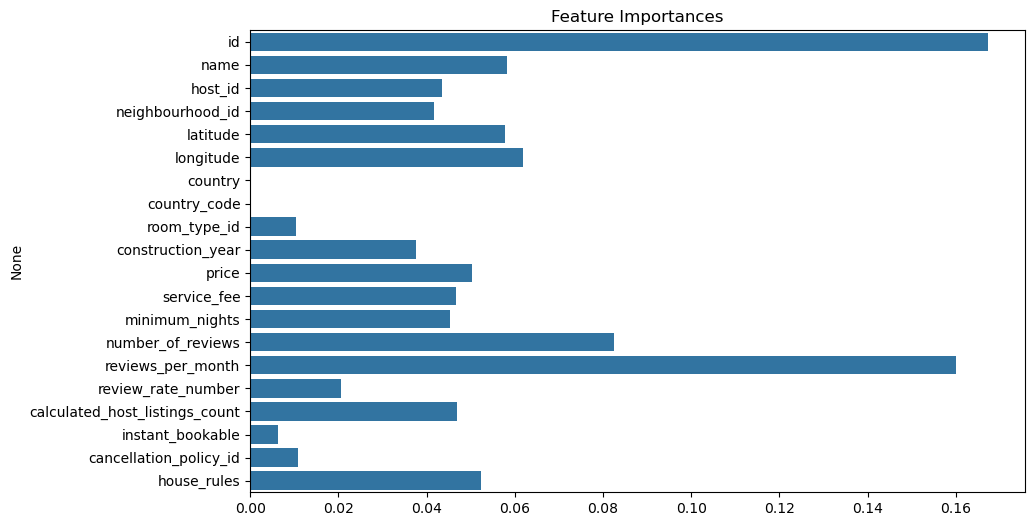

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()
